**Group Members**:
- Afonso Cadete | 20211519@novaims.unl.pt
- Catarina Oliveira | 20211616@novaims.unl.pt
- Joana Rosa | 20211516@novaims.unl.pt
- Rita Centeno | 20211579@novaims.unl.pt

# 3. Jupyter Notebook - Extract
# Feature Extraction and Feature Correlation / Association

This Jupyter Notebook has two main purposes; they are:
- perform feature extraction on the already existing and preprocessed dataset;
- assess the levels of correlation and association of the new and "old" features of the dataset.

In the next cell is where the importation of the needed libraries for the creation of new variables and the assessment of values for the correlation and association measurements is done.

In [1]:
# Libraries Importation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

## Opening the data

Akin to what happened in the previous documents and in the next ones, for the further analysis of the data, the preprocessed dataset has to be imported into this new notebook.

As so, that is what will be done in the next cell.

In [2]:
# Importation of the preprocessed dataset

# This path should be changed into the path where the Excel document "1Combine" was stored.
path = 'C:\\Users\\joana\\Documents\\Joana Rita\\Universidade\\Data Science\\Year 2\\1st Semester\\Programming for Data Science\\1st Project\\'

# Read the Excel document and define that the 'ID' column is the index of the dataset
data_original = pd.read_excel(path + '2Preprocess.xlsx', index_col='ID')

# Creating a copy of the imported data, so that the original one is never changed
data = data_original.copy()

# Calling the head of the dataset, to ensure the import was correctly done.
data.head()

,CostContact,Revenue,Age,NKids,NTeens,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NStorePurchases,NWebVisitsMonth,Response1,Response2,Response3,Response4,Response5,Response,Education,MaritalStatus
ID,,,,,,,,,,,,,,,,,,,,,
5314,3,11,65,0,1,40689.0,270,3,27,39,...,5,8,0,0,0,0,0,0,Graduation,Together
2493,3,11,50,0,1,61286.0,356,0,107,19,...,8,5,0,0,0,0,0,0,Graduation,Married
4931,3,11,39,0,0,157146.0,1,0,1725,2,...,0,1,0,0,0,0,0,0,Graduation,Together
1100,3,11,56,1,2,41275.0,24,4,22,0,...,3,5,0,0,0,0,0,0,Master,Together
7224,3,11,39,1,0,31353.0,10,0,10,3,...,2,8,0,0,0,0,0,0,Graduation,Married


As it is not possible to create new features mixing categorical and numerical variables, nor perform the assessment of the association between categorical variables without separating these two types of features of the dataset; in the next cell this separation was performed.

In [3]:
# Separation of categorical and numerical variables
data_numerical =  data.select_dtypes(include=np.number)
data_categorical = data.select_dtypes(exclude=np.number)

## Feature Extraction

In this step of the project, new variables resulting from the combination of already existing features of the dataset were created. This is a crucial step, because there combined features might have a better predictive power than just the individual variables.

#### Number of Minors in each Household

Starting with the smaller descriptive variables, a reasonable new variable to be created is `NMinors`, which consists of the sum of the number of minors in each customer household. It is important to mention that `NMinors` includes everyone in the customer's household which is younger than or equal to 19 years old (since teens end at 19 years old).

This variable will be able to evaluate the relevance of the existence of minors in the customer's household.

In [4]:
# definition of new variable NMinors which is the sum of NKids and NTeens
data['NMinors'] = data['NKids'] + data['NTeens']

#### Family Size

Following the previous path of thought, in terms of number of people in a customer's household, it can also be relevant to have the close family size of each customer.

To reach the final result of this variable, the value of each row of `NMinors` is summed with the number of adults in a household, which is obtained through the values of the `MaritalStatus` variable. If the customer is _Married_ or _Together_, it is considered that there are two adults in the household (minors + 2). Otherwise, (customer is _Single_, _Divorced_, _Widow_) it is only considered that there is only one adult in the household (minors + 1).

In [5]:
# for i in the index column:
for i in data.index:
    # if observation is Married or Together, family size is equal to minors plus 2
    if (data.loc[i, 'MaritalStatus'] == 'Married') or (data.loc[i, 'MaritalStatus'] == 'Together'):
        data.loc[i, 'FamilySize'] = data.loc[i, 'NMinors'] + 2
    # if observation is Single, Divorced or Widow, family size is equal to minors plus 1
    else:
        data.loc[i, 'FamilySize'] = data.loc[i, 'NMinors'] + 1

#### Monetary Total

As a way to have an overview on the customers total expenses in the company, it is believed that the creation of a total monetary variable is important. Such variable will be created below by summing the values of all monetary variables of each client (`MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`).

Additionally, and as it was explained in the previous notebook, `MntGoldProds` was not considered for this new variables as it is a subcategory of the monetary features.

In [6]:
# creates monetary total variable
data['MntTotal'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts']

#### Percentage of Income Spent (per customer)

Given that `MntTotal` is equivalent to the expenses in the company made by the client in a temporal space of 2 years and `Income` only refers to the sum of received salaries in a year, it is quite interesting to figure out how much of the income gained was spend in company products. As so, that is what `%IncomeSpent` represents.

Firstly, it is needed to adjust the scale of the variables. This is achieved by dividing the values of `MntTotal` by two and then divide it by the Income while afterwards multiplying it by 100 to get the percentage. The values this new variable were rounded up to three decimal cases, just for simplicity of the obtained results.

In [7]:
# creation of %IncomeSpent variable
data['%IncomeSpent'] = ((data['MntTotal'] / 2) / data['Income']) * 100
# rounds up %IncomeSpent to 3 decimal cases
data['%IncomeSpent'] = data['%IncomeSpent'].round(3)

#### Total Number of Purchases (per customer) through all sales channels

Similarly to what happens in `MntTotal`, an overview of the total number of purchases made by a customer in the company, ever since he became a customer, might also be relevant to understand which customers bought the target campaign. For this, the sum of the number of sales through the 3 possible sales channels (web purchases + catalog purchases + store purchases) was computed.

In [8]:
# creates total purchases variable
data['TotalPurchases'] = data['NWebPurchases'] + data['NCatalogPurchases'] + data['NStorePurchases']

#### Total Number of Responses (per customer) to all Marketing Campaigns

Furthermore, a variable which has the total number of responses, per customer, is going to be computed in the next cell.
This feature might reveal itself useful to later understand to how many campaigns did the best customers positively responded to.

In [9]:
# creates total responses variable
data['TotalResponses'] = data['Response1'] + data['Response2'] + data['Response3'] + data['Response4'] + data['Response5']

#### Number of Days between each Purchase

Another variable that might be interesting to analyse is the number of days between each purchase of a specific customer (row of the dataset).
This is due to the fact that not only the loyalty of the client matters, but also its purchases' reoccurrence. For example, it would not make sense to have a customer which was a client for 2 years but also has two years between the purchases.

This specific feature can be computed through the division of the values of the `Longevity` feature by the ones of `Total Purchase`. Afterwards, `NDaysPurchase` was transformed into a variable of integer 64 bit format.

In [10]:
# creates number of days between each purchase variable
data['NDaysPurchase'] = data['Longevity'] / data['TotalPurchases']
# transforms NDaysPurchase to an integer format variable
data['NDaysPurchase'] = data['NDaysPurchase'].astype('int64')

The next cell will call the head of the dataset just to verify if all the above created variables were rightfully added to the datasset.

In [11]:
data.head(3)

,CostContact,Revenue,Age,NKids,NTeens,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Response,Education,MaritalStatus,NMinors,FamilySize,MntTotal,%IncomeSpent,TotalPurchases,TotalResponses,NDaysPurchase
ID,,,,,,,,,,,,,,,,,,,,,
5314,3,11,65,0,1,40689.0,270,3,27,39,...,0,Graduation,Together,1,3.0,345,0.424,13,0,92
2493,3,11,50,0,1,61286.0,356,0,107,19,...,0,Graduation,Married,1,3.0,491,0.401,16,0,66
4931,3,11,39,0,0,157146.0,1,0,1725,2,...,0,Graduation,Together,0,2.0,1729,0.550,28,0,41


As all new variables are present in the above head of the dataset, and their values are in concordance with the formulas used to create them, further analysis can be performed on the dataset's features.

#### Descriptive Statistics of the New Variables

Similarly to what was done in the previous notebook for the original variable of the dataset, in the next cells the descriptive statistics of the new variables will be computed and briefly analysed.

In [12]:
# creates a list with the new variables
# ft is the shortform for features
new_ft = ['Age','Longevity','NMinors','FamilySize','MntTotal','%IncomeSpent','TotalPurchases','NDaysPurchase','TotalResponses']

# computed and prints the descriptive statistics of the new variables
data[new_ft].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2036.0,47.225442,11.947870,20.000,39.000,46.0000,57.00000,123.000
Longevity,2036.0,1084.532908,201.876466,733.000,911.000,1084.0000,1259.50000,1432.000
NMinors,2036.0,0.948428,0.748983,0.000,0.000,1.0000,1.00000,3.000
FamilySize,2036.0,2.590864,0.904857,1.000,2.000,3.0000,3.00000,5.000
MntTotal,2036.0,564.989194,578.275725,6.000,55.000,343.0000,964.25000,2491.000
%IncomeSpent,2036.0,0.453617,0.856682,0.004,0.095,0.3475,0.71825,35.329
TotalPurchases,2036.0,12.546169,7.148432,1.000,6.000,12.0000,18.00000,32.000
NDaysPurchase,2036.0,130.990177,105.288017,26.000,59.000,92.0000,179.00000,1419.000
TotalResponses,2036.0,0.301081,0.679803,0.000,0.000,0.0000,0.00000,4.000


From the above descriptive statistics table it is possible to check that these new features do not have any missing values, which was already expected due to the fact that they come from variables that were previously treated for missing values.

The `Age` feature seems to be pretty normally distributed given that its values of the mean and median are akin to each other. The existence of outliers in this variable was already shown through the evaluation of data inconsistencies of `BirthYear` in the second notebook (preprocess). This can also be deduced through the difference of values from the third to the fourth quartile of this variable.

In the `Longevity` feature, the value of the mean is equal to the one of the median, which can indicate that this is an approximately normally distributed variables. This will be checked through the plotting of the histogram below. There is also not much of a noticeable difference in the values of the four quartiles.

`NMinors` is a discrete variable, therefore there are not many conclusions that can be taken from the above descriptive statistics table. The same happens to the feature `FamilySize`. However, the second quartile holds an equal value to the third one.

In regard to `MntTotal`, it seems to be a right-skewed distribution. This will later be checked with the histograms.

`%IncomeSpent` also has a large value of standard deviation, which once again leads to the conclusion of high variability of the data. It can also be seen that there exists a great difference of values between the 3rd and 4th quartile values; such case can lead to the most certain indication of the existence of outliers in this feature of the dataset.

As for `TotalPurchases`, is a discrete variable. As so, further conclusions should be taken from the evaluation of bar charts.
`NDaysPurchase` does not seem to be normally distributed, since the mean is very different from median.

Finally, `TotalResponses` has a large value for the standard deviation which indicated high variability of the data for these variables. In context, this can be given to the fact that in the 2036 customers, none of them answered positively to the campaigns in the same way.

**Histograms to justify the conclusions of the descriptive statistics**

Similarly to what was done in the previous notebook for the original variables of the dataset, will now be done for the newly created variables. Through the below computed histograms it is possible to have a general idea of the type of distribution each variable has.

Histograms can only be applied to continuous variables, as so the new variables were divided into two lists (one for continuous and the other for discrete variables).

In [13]:
# creates a list with new variables which are continuous
new_ft_cont = ['Age','Longevity','MntTotal','%IncomeSpent','NDaysPurchase']

# creates a list with new variables which are discrete
new_ft_dis = ['NMinors','FamilySize','TotalPurchases','TotalResponses']

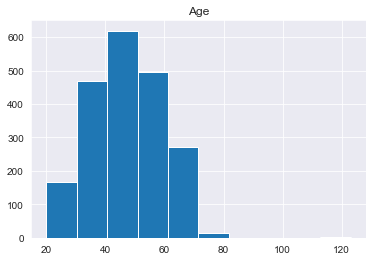

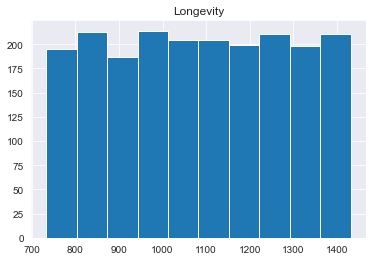

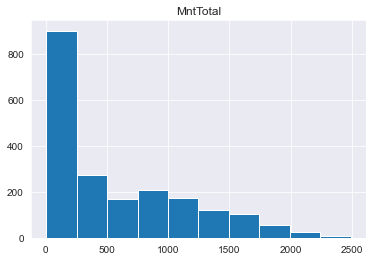

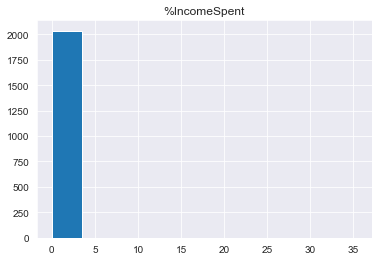

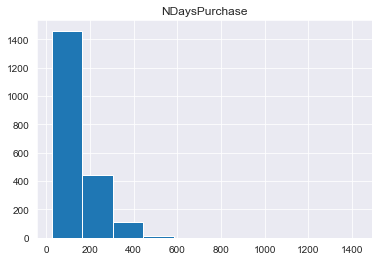

In [14]:
# for var in list of new continuous variables creates a histogram
for var in new_ft_cont:
    plt.title(var)
    plt.hist(data[var])
    plt.show()

The plotting of these histograms confirmed the following conclusions already mentioned in the description of the statistics of the new variables:
- `Age` is normally distributed and the effect of the outliers make visible the existence of a slight right tail;
- `Longevity` does not follow a normal distribution, all peaks of the histogram are at similar heights;
- `MntTotal`,`NDaysPurchases` are right-skewed variable;
- `%IncomeSpent` is represented by an only column histogram, which might indicate the existence of outliers in this variable.

**Bar charts to justify the conclusions of the descriptive statistics**

For the discrete variables, defined in the list `new_ft_dis`, bar charts were plotted with the same goal of the plotting of the histograms.

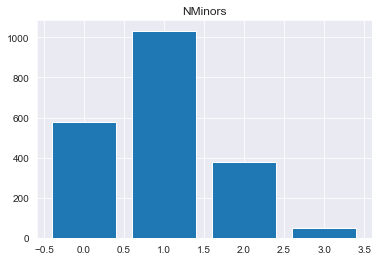

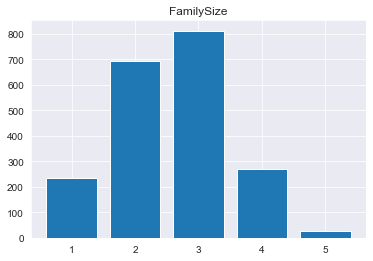

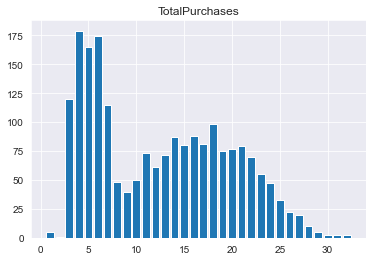

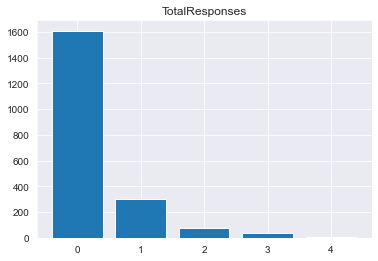

In [15]:
# for var in list of new discrete variables creates a histogram
for var in new_ft_dis:
    plt.title(var)
    plt.bar(data[var].value_counts().index, data[var].value_counts().values)
    plt.show()

From the above bar charts, it is possible to reach the following conclusions:
- the variable `NMinors` has a mode equal to 1, which means that most of the customers only have one minor under their responsibility;
- in the `FamilySize` feature, the mode is equal to 3. As so, it can be said that most of the households are composed by three people;
- the mode of `TotalPurchases` is equal to 4. Therefore, most customers have made fours purchases in the company;
- finally, in variable `TotalResponses` the mode is equal to 0, which indicates that most of the customers of the dataset negatively answered to the marketing campaigns.

## Correlation

The term correlation can be briefly described as the level at which two variables are linearly related. And the correlation coefficient as the measurement of the strength of the linear relationship between two variables. Furthermore, the values of the correlation coefficient ought to be between -1 and 1.

### Spearman Correlation Coefficient Matrix

As a way to measure the level of correlation between the continuous and discrete variables of the dataset, a Spearman correlation coefficient matrix was plotted below.
The method of Spearman correlation was chosen over the Pearson one, since Spearman can handle both discrete and continuous variables, while Pearson only accepts the latter.

It is also important to mentioned that Spearman correlation automatically discriminates between numerical and categorical features. Therefore, it is not needed to previously make this distinction between these two types of variables.

In [16]:
# applies the spearman correlation method to the data
corr_spearman = data.corr(method = "spearman")

In [17]:
# definition of a function that creates lower triangular correlation heatmaps
def correlation_map(cor):
    # creates mask
    mask = np.triu(np.ones_like(cor))

    # plots the heatmap
    fig = plt.figure(figsize=(20,10), dpi = 480)
    heatmap = sns.heatmap(cor, cmap="YlGnBu", annot=True, mask=mask, fmt='.1')

    # prints the heatmap
    plt.show()

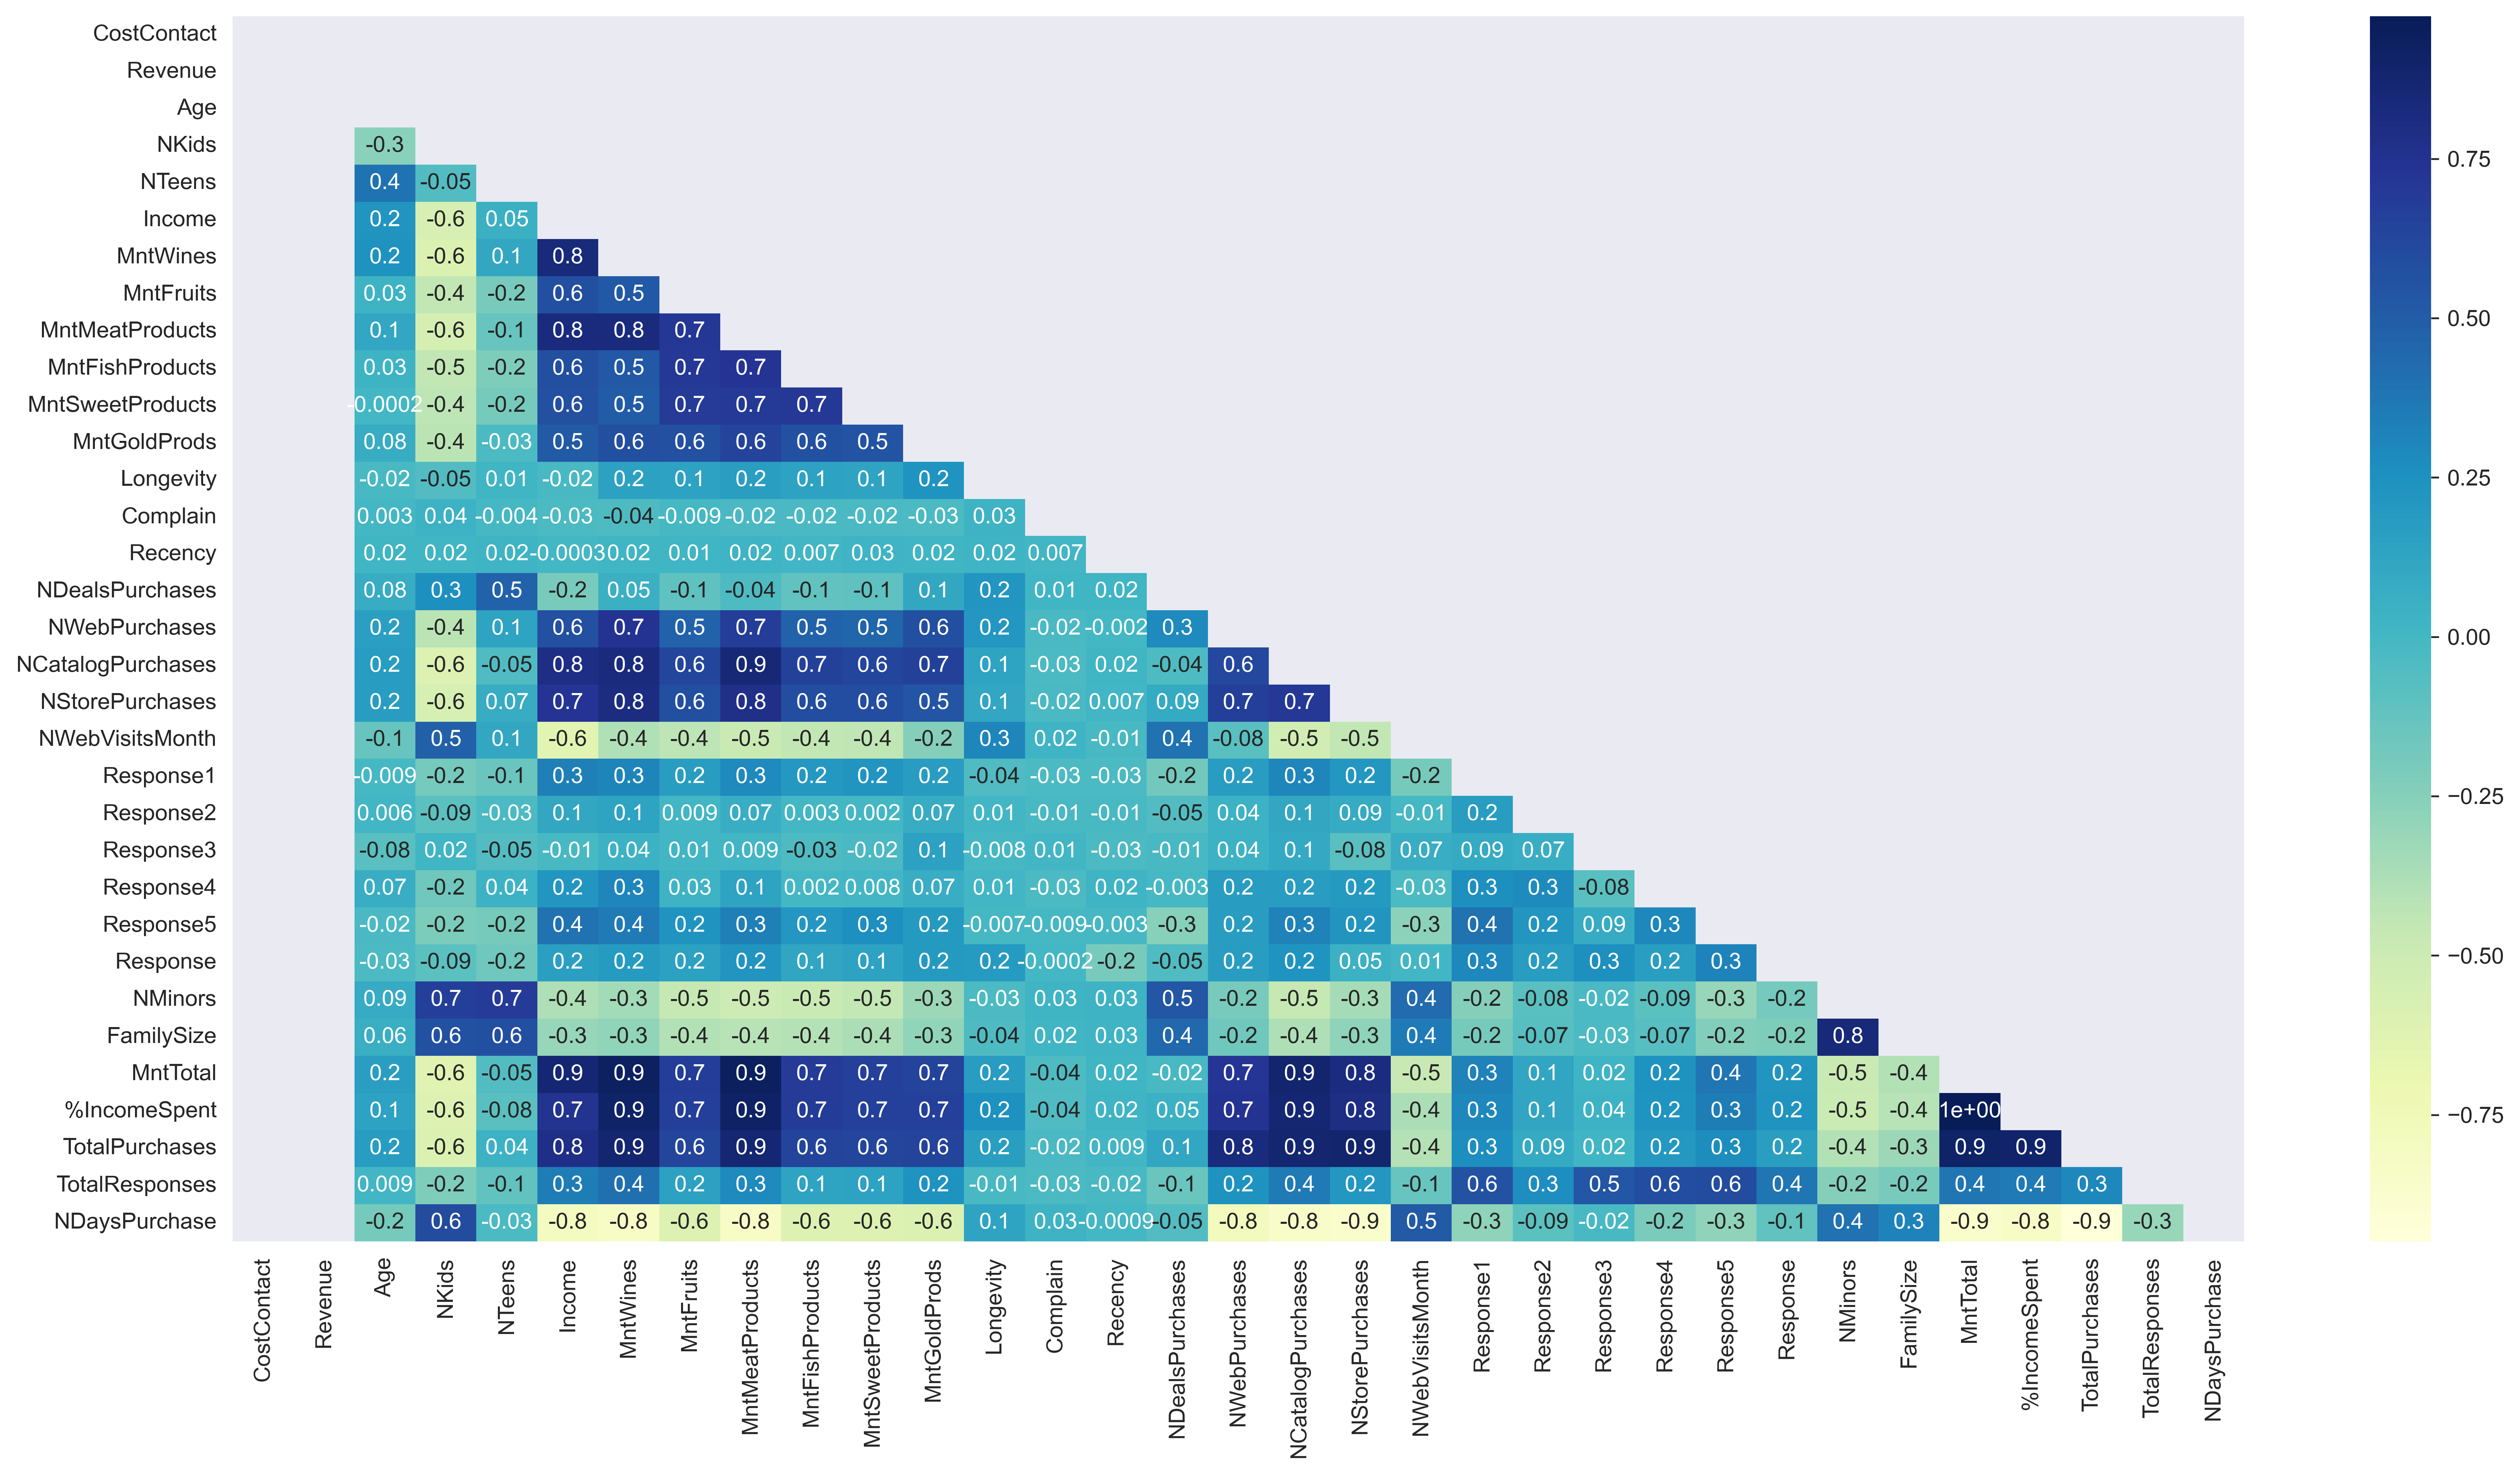

In [18]:
# calls the function which plots the correlation matrix with the values of corr_spearman
correlation_map(corr_spearman)

The first two columns and rows of the correlation matrix (`Cost Contact`, `Revenue`) appear with no values due to the fact that they are constants with the values 3 and 11, respectively. Therefore, being useless to the evaluation and analysis of the problem being studied. As so and to facilitate the interpretation of results and further analysis in new notebooks these two variables will be dropped in the next cell.

The `Response` variables does not have any high correlation relationship with other variables of the dataset. The highest one is found with `TotalResponses` (value near 0,4) and with `Response 1`, `Response 3` and `Response 5` (all with values near 0,3).

Nevertheless, it is possible to verify that the matrix has relatively high values of correlation between features, namely the new features. This does indeed make a lot of sense, since the new features of the dataset originate from already existing features.

In [19]:
# drops the variables CostContact and Revenue
data.drop(['CostContact', 'Revenue'], axis = 1, inplace = True)

After the deletion of the variables with the constant values, it is time to identify the more accentuated values of correlation between the variables fo the dataset.
As there are several values near 0,7 and 0,8, in the below cell only the correlation values higher than 0,9 were considered as crucial. In this way, it is possible to avoid overfitting as well as avoiding the error of eliminating too many features out of the dataset.

In [20]:
# defines a variable with all the columns of the dataset
x = data.columns

sp = data.loc[:, x].corr(method="spearman")
corr_spearman_flat = sp.stack()
tri_u = np.triu(np.ones(sp.shape)).astype('bool').reshape(sp.size)
corr_spearman_flat = corr_spearman_flat[tri_u]

# removes the low-correlated pairs and the auto-correlations
l_threshold = 0.9
u_threshold = 1
srcc_top = corr_spearman_flat[(corr_spearman_flat.abs() > l_threshold) & (corr_spearman_flat.abs() < u_threshold)]

# prints the output of highly correlated pairs of variables
print("Top Most Correlated Feature Pairs:\n", srcc_top.abs())

Top Most Correlated Feature Pairs:
 MntWines         MntTotal          0.933931
                 %IncomeSpent      0.908830
MntMeatProducts  MntTotal          0.942610
                 %IncomeSpent      0.916640
MntTotal         %IncomeSpent      0.973587
                 TotalPurchases    0.909253
TotalPurchases   NDaysPurchase     0.948591
dtype: float64


As it is possible to verify in the above output, there are 7 correlation pairs which have a higher correlation value than 0,9 (note that some features are highly correlated with more than one feature).

These are: `MntTotal` (4 pairs of correlations); `%IncomeSpent` (3 pairs of correlations); `MntWines` (2 pairs of correlations); `TotalPurchases` (2 pairs of correlations); `NDaysPurchase` (2 pairs of correlations).

Given this, and in a quick first analysis, it can be stated that there exists the possibility of only variables `MntTotal` and `NDaysPurchase` translating into a good representation of all the 7 highly correlated variables.

## Chi-Squared for Categorical Variables

Given the fact that the correlation of the categorical variables cannot be evaluated through the Spearman correlation coefficient matrix; another method for this specific type of variables needs to be applied. The chosen method is the Test of Independence using Chi-Square.

The below computed function makes use of the spicy.stats library as a way to optimize the process of evaluation of the p-value. As so, this function is defined in the following five main steps:
- a table, where the quantity of occurrences of every class of the categorical feature is divided by the possible values of the outcome,is created;
- chi-squared is computed alongside the p-value, the number of degrees of freedom (of the chi-square distribution) and the expected frequencies for the present values in the prior built table;
- expected values are formatted in order to facilitate the comparison of the original table;
- through a defined condition, the p-value obtained is compared with alpha (0,5) and the hypothesis "if the categorical variable is or not a good predictor of the outcome" is either accepted or rejected;
- finally, the result is printed.

Given this brief explanation of the function and by analyzing the cell below it is possible to conclude that the third step does not influence the final obtained result. Nevertheless, it is a good practice to compare the original table with the expected one, as a way to obtain a higher difference of values and better outputs.

In [21]:
# defines the test of independence function
def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Response".format(var)
    else:
        result="{0} is NOT an important predictor of Response. (Discard {0})".format(var)
    print(result)

Being the test of independence defined, it is now the moment to apply it to the categorical variables of the dataset in study - `Education` and `MaritalStatus`.
For this to be accomplished, a for loop where each categorical variable is compared with the target variable - `Response` - was created.

In [22]:
# prints the defined string
print('Final conclusion of Chi-squared:\n')

# for var in categorical data variable, test of independence is performed
for i in data_categorical:
    TestIndependence(data_categorical[i], data['Response'], i)

Final conclusion of Chi-squared:

Education is IMPORTANT for Response
MaritalStatus is IMPORTANT for Response


With the above output in mind, it is not necessary to drop any categorical variable, since they are both important variables to reach the value of `Response`.

Data exportation with new alterations to an Excel file.

In [23]:
data.to_excel(path + "3Extract.xlsx")